In [1]:
pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 6.2 MB/s 
     |████████████████████████████████| 38.1 MB 2.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
pip install pyinform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 131 kB 7.5 MB/s 


In [6]:
#Para usarlas es necesario instalar e importar las librerias networkx, numpy y nilearn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nilearn import connectome
import pyinform as pyin
import pandas as pd

def conectividad_mutual_entropy(time_series):
  time_series = time_series + np.abs(np.min(time_series))
  conectividad = np.zeros((len(time_series),len(time_series)))
  for i in range(len(time_series)):
    for j in range(i+1,len(time_series)):
      value = pyin.mutual_info(time_series[i],time_series[j])
      conectividad[i][j] = value
      conectividad[j][i] = value
  np.fill_diagonal(conectividad,0.0)
  return conectividad

def metropolis_hastings(M, iteraciones, reinicios, T, acople, resistencia, high = 1.0, low = -1.0):

  graf = nx.convert_matrix.from_numpy_array(M, parallel_edges=False, create_using = nx.DiGraph())
  graf.remove_edges_from(nx.selfloop_edges(graf))

  # Array en el que se depositan las series de tiempo de los nodos
  time_series = np.zeros((len(graf.nodes()), reinicios*iteraciones))
  # Array en el que se depositan las energias asociadas a cada estado de la red en cada iteracion
  E = np.zeros(reinicios*iteraciones)

  # Un vector donde se seleccionan aleatoriamente los nodos a los que se les cambiara su estado
  n = np.random.choice(graf.nodes(), size = reinicios*iteraciones)
  # Vector de numeros aleatorios para 
  number = np.random.rand(reinicios*iteraciones)

  for reinicio in range(reinicios):
  
    # Se crea un valor de spin para cada nodo aleatoriamente (condiciones iniciales)
    for i in graf.nodes():
        graf.nodes[i]['state'] = high if np.random.rand() < 0.5 else low

    energia = 0.0
    for nodes in graf.nodes():
      energia_nodo = graf.nodes[nodes]['state']*(resistencia[nodes]/2.0) -(acople/2.0)*graf.nodes[nodes]['state']*np.sum(graf.nodes[vecinos]['state']*M[nodes,vecinos] for vecinos in graf.predecessors(nodes))
      energia += energia_nodo

    for i in range(iteraciones):

      estado_previo = graf.nodes[n[reinicio*iteraciones + i]]['state']

      graf.nodes[n[reinicio*iteraciones + i]]['state'] = high if estado_previo == low else low 

      energia_cambio = 0.0
      for nodes in graf.nodes():
        energia_nodo = graf.nodes[nodes]['state']*(resistencia[nodes]/2.0) -(acople/2.0)*graf.nodes[nodes]['state']*np.sum(graf.nodes[vecinos]['state']*M[nodes,vecinos] for vecinos in graf.predecessors(nodes))
        energia_cambio += energia_nodo

      de = energia_cambio - energia

      if de < 0:
        energia = energia_cambio
      else:
        p = np.exp(-de/T)
        if number[reinicio*iteraciones + i] < p:
          energia = energia_cambio
        else:
          graf.nodes[n[reinicio*iteraciones + i]]['state'] = estado_previo

      E[reinicio*iteraciones + i] = energia

      for k in graf.nodes():
        time_series[k, reinicio*iteraciones + i] = graf.nodes[k]["state"]

  return E, time_series

def calculo_entropia(energias,particiones):
  rango = max(energias) - min(energias)
  ancho_intervalo = rango/particiones
  punto_inicio = min(energias)
  frecuencias = []
  for i in range(particiones):
    y = 0 
    for x in energias:    
      a = punto_inicio + (i*ancho_intervalo)
      b= punto_inicio +  (i+1)*ancho_intervalo
      if i == particiones:
        if x >=  a and x<= b:
          y +=1
      if i != particiones:
        if x >=  a and x< b:
          y +=1
    frecuencias.append(y)
    
  suma_entropia = 0
  for i in frecuencias:
    probabilidad = i/len(energias)
    if probabilidad != 0:
      suma_entropia -= probabilidad*np.log(probabilidad)
  return suma_entropia

In [4]:
#%% Conectar con google drive, donde se encuentran los datos HCP1200 requeridos
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [5]:
cd /gdrive/Shareddrives/GENSyR /CNF (Complejidad y NeuroFísica)/Carpeta de trabajo/Tesis Juan y Diego /Datos Poblaciones/Sujetos Tesis

/gdrive/Shareddrives/GENSyR /CNF (Complejidad y NeuroFísica)/Carpeta de trabajo/Tesis Juan y Diego /Datos Poblaciones/Sujetos Tesis


In [7]:
sujetos = ['Emotion_F-']
estructurales = []
for sujeto in sujetos:
  estructural = np.load(sujeto+ '/EST_sum_no_norm_' + sujeto + '.npy')
  estructurales.append(estructural)

In [8]:
Temperatura1 = 0.1665
M = estructurales[0]
E, time_series = metropolis_hastings(M, iteraciones = 400, reinicios = 1000, T = Temperatura1, acople = 1.0, resistencia = np.zeros(M.shape[0]), high = 1.0, low = -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [9]:
SIM = conectividad_mutual_entropy(time_series)

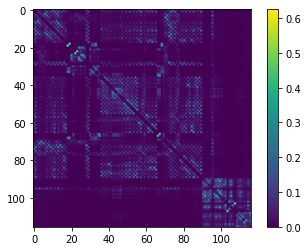

In [10]:
plt.imshow(SIM)
plt.colorbar()